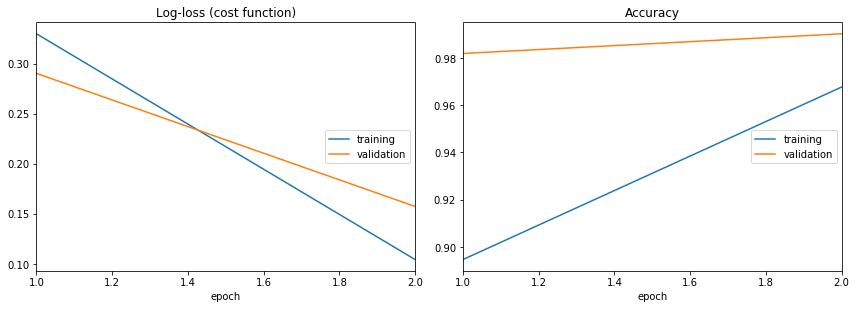

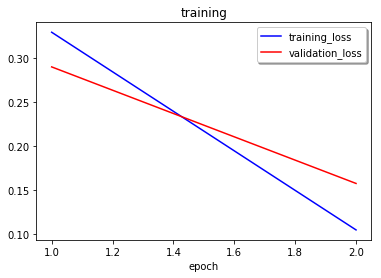

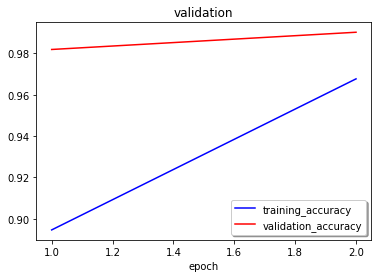

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, CSVLogger

TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_FILE = "model.h5"
TRAINING_PLOT_FILE = "training.png"
VALIDATION_PLOT_FILE = "validation.png"
GOOGLE_COLAB = False

if GOOGLE_COLAB:
    !pip install livelossplot
from livelossplot import PlotLossesKeras

VERBOSITY = 1
EPOCHS = 2 
BATCH_SIZE = 128
CLASSES = 10
CHANNELS = 1
IMAGE_SIZE = 28
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
VALIDATION_RATIO = 0.1

# Load the data
path = "/Users/grzegorzsurma/Datasets/digits"

if GOOGLE_COLAB:
    from google.colab import drive, files
    drive.mount('/content/drive/')
    path = "/content/drive/My Drive/datasets/digits/"
train = pd.read_csv(path + "/train.csv")
test = pd.read_csv(path + "/test.csv")

y = train["label"]
x = train.drop(labels = ["label"], axis = 1) 

# Reshape data
x = x.values.reshape(-1, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)
test = test.values.reshape(-1, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)

# One Hot encoding
y = to_categorical(y, num_classes=CLASSES)

# Prepare training/validation sets
x_training, x_validation, y_training, y_validation = train_test_split(x, y, test_size=VALIDATION_RATIO)

# Model
model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size=(5,5),
                 padding='Same', 
                 activation='relu',
                 input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)))
model.add(Conv2D(filters=32,
                 kernel_size=(5,5),
                 padding='Same', 
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same', 
                 activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same', 
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(CLASSES, activation="softmax"))

model.compile(optimizer=RMSprop(lr=0.001,
                                rho=0.9,
                                epsilon=1e-08,
                                decay=0.0),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

with open(MODEL_SUMMARY_FILE,"w") as fh:
    model.summary(print_fn=lambda line: fh.write(line + "\n"))

# Data augmentation
data_generator = ImageDataGenerator(rescale=1./255,
                                    rotation_range=5,
                                    zoom_range=0.1, 
                                    width_shift_range=0.05,
                                    height_shift_range=0.05)
data_generator.fit(x_training)

# Training
history = model.fit_generator(data_generator.flow(x_training,
                                                  y_training,
                                                  batch_size=BATCH_SIZE),
                              epochs=EPOCHS,
                              validation_data=(x_validation, y_validation),
                              verbose=VERBOSITY,
                              steps_per_epoch=x_training.shape[0] // BATCH_SIZE,
                              callbacks=[ReduceLROnPlateau(monitor='val_acc', 
                                                           patience=3, 
                                                           verbose=1, 
                                                           factor=0.5, 
                                                           min_lr=0.00001),
                                         PlotLossesKeras(),
                                         CSVLogger(TRAINING_LOGS_FILE,
                                                   append=False,
                                                   separator=";")])
model.save_weights(MODEL_FILE)

# Drawing plots
epochs = [i for i in range(1, len(history.history['loss'])+1)]

plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
plt.legend(loc='best', shadow=True)
plt.title('training')
plt.xlabel('epoch')
plt.savefig(TRAINING_PLOT_FILE, bbox_inches='tight')
plt.show()
plt.close()

plt.plot(epochs, history.history['acc'], color='blue', label="training_accuracy")
plt.plot(epochs, history.history['val_acc'], color='red',label="validation_accuracy")
plt.legend(loc='best', shadow=True)
plt.title('validation')
plt.xlabel('epoch')
plt.savefig(VALIDATION_PLOT_FILE, bbox_inches='tight')
plt.show()
plt.close()

# Downloadign data if necessary
if GOOGLE_COLAB:
    files.download(MODEL_SUMMARY_FILE)
    files.download(MODEL_FILE)
    files.download(TRAINING_LOGS_FILE)
    files.download(VALIDATION_PLOT_FILE)
    files.download(TRAINING_PLOT_FILE)
